In [85]:
import numpy as np 
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

import optuna
from sklearn.utils import class_weight

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    roc_curve, 
    confusion_matrix,
    precision_recall_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
    auc
)

import warnings

warnings.filterwarnings('ignore')

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv


In [91]:
# download samples
train_data = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')

In [3]:
features_list = list(train_data.drop(['id', 'loan_status'], axis = 1).columns)
num_features = train_data[features_list].select_dtypes(include=['number']).columns.to_list()
cat_features = train_data[features_list].select_dtypes(include=['object']).columns.to_list()

In [4]:
train_data.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [5]:
train_data[num_features].describe(percentiles = (np.arange(0, 1, 0.1)))

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
count,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556
std,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196
min,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000
0%,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000
10%,22.000000,3.120000e+04,0.000000,3000.000000,6.760000,0.060000,2.000000
20%,23.000000,3.948000e+04,1.000000,5000.000000,7.510000,0.080000,3.000000
30%,24.000000,4.500000e+04,2.000000,5600.000000,8.000000,0.100000,3.000000
40%,25.000000,5.000000e+04,3.000000,7000.000000,9.990000,0.120000,4.000000
50%,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000


In [6]:
test_data[num_features].describe(percentiles = (np.arange(0, 1, 0.1)))

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
count,39098.000000,3.909800e+04,39098.000000,39098.000000,39098.000000,39098.000000,39098.000000
mean,27.566781,6.406046e+04,4.687068,9251.466188,10.661216,0.159573,5.830707
std,6.032761,3.795583e+04,3.868395,5576.254680,3.020220,0.091633,4.072157
min,20.000000,4.000000e+03,0.000000,700.000000,5.420000,0.000000,2.000000
0%,20.000000,4.000000e+03,0.000000,700.000000,5.420000,0.000000,2.000000
10%,22.000000,3.141600e+04,0.000000,3000.000000,6.760000,0.060000,2.000000
20%,23.000000,4.000000e+04,1.000000,5000.000000,7.510000,0.080000,3.000000
30%,24.000000,4.500000e+04,2.000000,6000.000000,8.000000,0.100000,3.000000
40%,25.000000,5.000000e+04,3.000000,7000.000000,9.990000,0.120000,4.000000
50%,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000


In [7]:
train_data.dtypes

id                              int64
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
loan_status                     int64
dtype: object

In [8]:
train_data.isna().sum()

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [9]:
# target distribution
train_data['loan_status'].value_counts(normalize=True)

loan_status
0    0.857618
1    0.142382
Name: proportion, dtype: float64

## Feature Selection

In [10]:
def const_feature(df, features_lst, N):
    """
        Function for deleting const features
        Parameters:
            df: pd.Dataframe
            features_lst: list
               list of features
            N: float
                The percentage for a constant value in the sample
    """
    features_list = features_lst.copy()
    
    # list for const features
    wrong_features = list()
    for feature in features_list:
        # calculate the share of the maximum value in the feature from the total
        # if the share is greater than N, add the feature to the list for deletion
        if (df[feature].value_counts().head(1).unique() / df.shape[0]) > N:
            wrong_features.append(feature)

    return wrong_features

In [11]:
print('List of const features: ',  const_feature(train_data, features_list, 0.9))

List of const features:  []


In [12]:
features_list = list(set(features_list) - set('loan_percent_income'))

<Axes: >

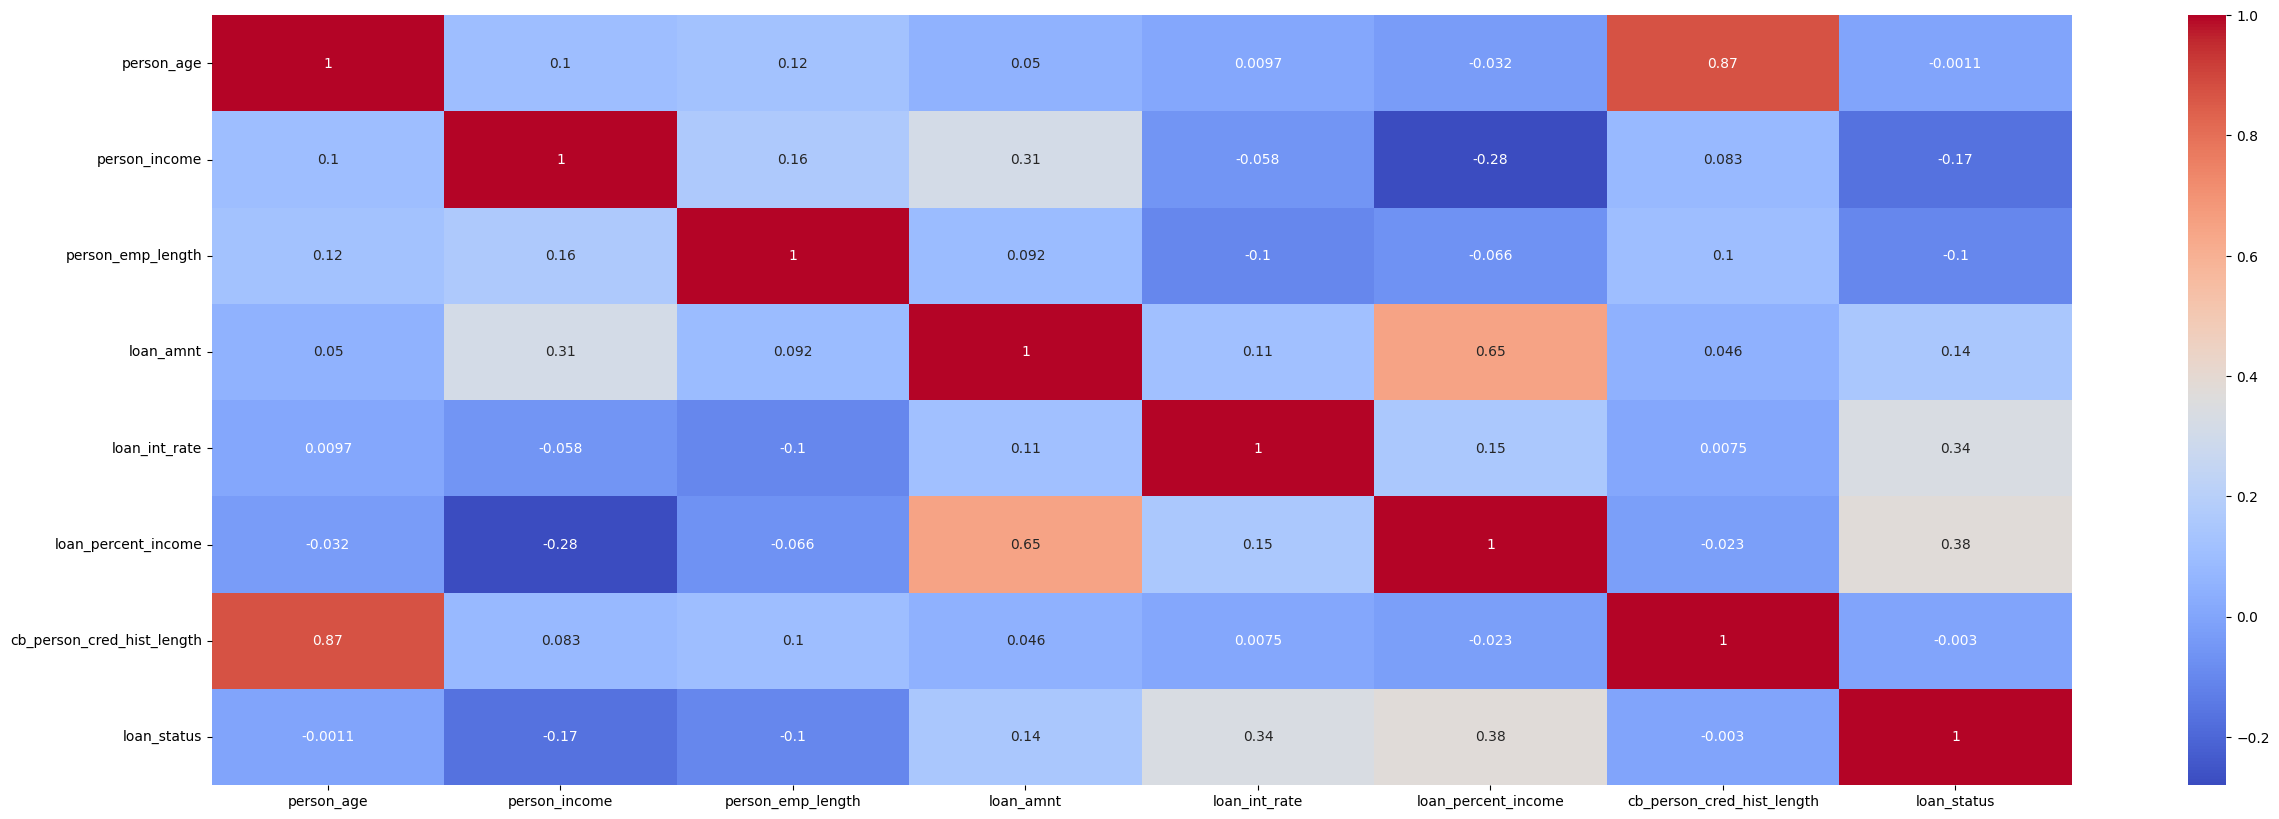

In [13]:
plt.figure(figsize=(30, 10))
sns.heatmap(train_data[num_features + ['loan_status']].abs().corr(), annot = True, cmap= 'coolwarm')

In [14]:
# conversion of categorical features
train_data = pd.get_dummies(train_data, columns=cat_features, drop_first=True)

In [15]:
bool_features = list(train_data.columns[train_data.dtypes == bool])

train_data[bool_features] = train_data[bool_features].astype(int)

In [16]:
train_data.head(5)

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,person_home_ownership_OTHER,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
0,0,37,35000,0.0,6000,11.49,0.17,14,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1,22,56000,6.0,4000,13.35,0.07,2,0,0,...,1,0,0,0,1,0,0,0,0,0
2,2,29,28800,8.0,6000,8.90,0.21,10,0,0,...,0,1,0,0,0,0,0,0,0,0
3,3,30,70000,14.0,12000,11.11,0.17,5,0,0,...,0,0,1,1,0,0,0,0,0,0
4,4,22,60000,2.0,6000,6.92,0.10,3,0,0,...,1,0,0,0,0,0,0,0,0,0


## EDA analysis

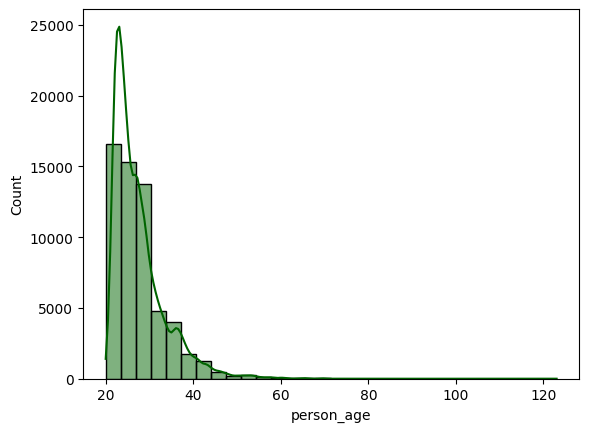

In [67]:
sns.histplot(train_data['person_age'], kde=True, bins=30, color = 'darkgreen')
plt.show()

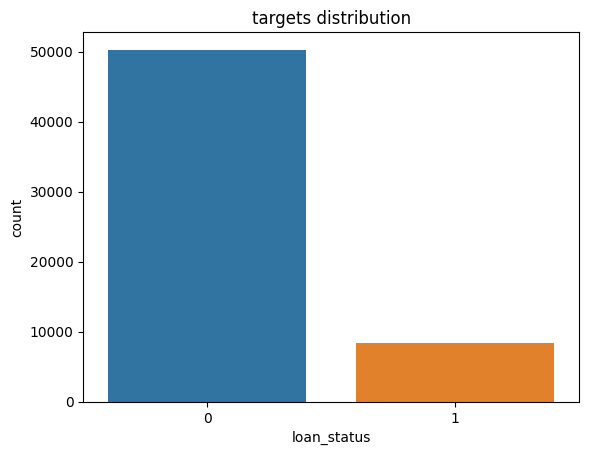

In [72]:
sns.countplot(x='loan_status', data=train_data)
plt.title('targets distribution')
plt.show()

------Фича person_age------


count    58645.000000
mean        27.550857
std          6.033216
min         20.000000
25%         23.000000
50%         26.000000
75%         30.000000
max        123.000000
Name: person_age, dtype: float64

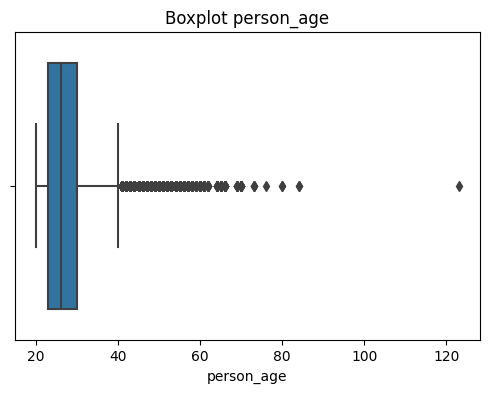

------Фича person_income------


count    5.864500e+04
mean     6.404617e+04
std      3.793111e+04
min      4.200000e+03
25%      4.200000e+04
50%      5.800000e+04
75%      7.560000e+04
max      1.900000e+06
Name: person_income, dtype: float64

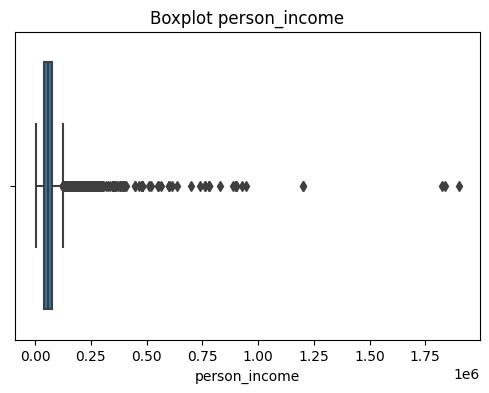

------Фича person_emp_length------


count    58645.000000
mean         4.701015
std          3.959784
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        123.000000
Name: person_emp_length, dtype: float64

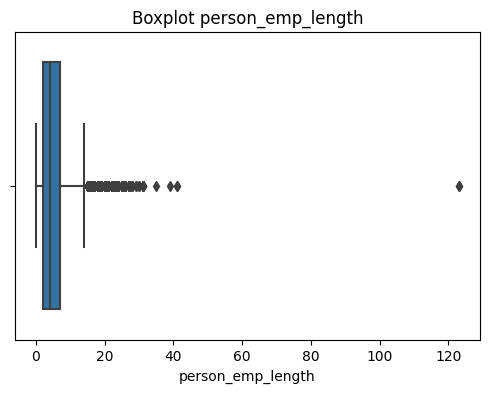

------Фича loan_amnt------


count    58645.000000
mean      9217.556518
std       5563.807384
min        500.000000
25%       5000.000000
50%       8000.000000
75%      12000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

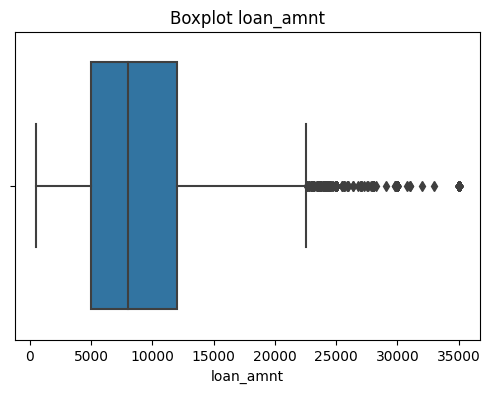

------Фича loan_int_rate------


count    58645.000000
mean        10.677874
std          3.034697
min          5.420000
25%          7.880000
50%         10.750000
75%         12.990000
max         23.220000
Name: loan_int_rate, dtype: float64

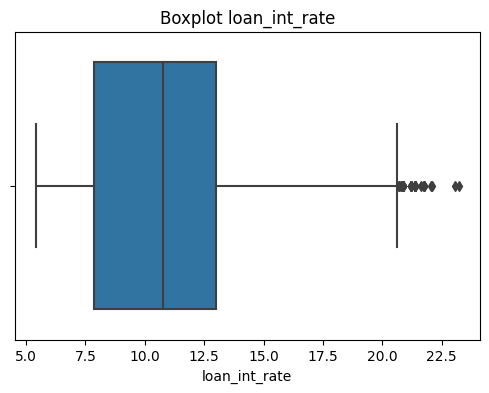

------Фича loan_percent_income------


count    58645.000000
mean         0.159238
std          0.091692
min          0.000000
25%          0.090000
50%          0.140000
75%          0.210000
max          0.830000
Name: loan_percent_income, dtype: float64

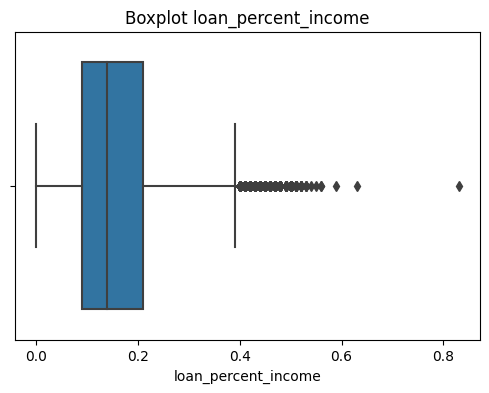

------Фича cb_person_cred_hist_length------


count    58645.000000
mean         5.813556
std          4.029196
min          2.000000
25%          3.000000
50%          4.000000
75%          8.000000
max         30.000000
Name: cb_person_cred_hist_length, dtype: float64

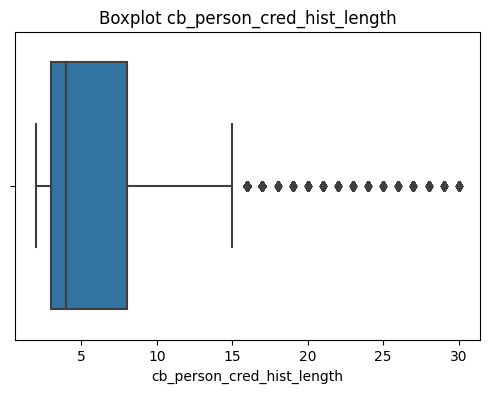

In [84]:
# function for visialisating outliers
def box_plot(df, features):
    """
        Function for visialisating outliers
        Parameters:
            df: pd.Dataframe
            features: list
               list of features
    """
    for column in features:
        print(f'------Feature {column}------')
        display(df[column].describe())
        plt.figure(figsize=(6, 4))
        sns.boxplot(x=df[column])
        plt.title(f'Boxplot {column}')
        plt.show()
box_plot(train_data, num_features)

## Splitting data into train and valid set

In [17]:
X = train_data.drop(['loan_status'], axis = 1)
y = train_data['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state = 42)

In [18]:
print('Train size: ', X_train.shape)
print('Test size: ',  X_test.shape)

Train size:  (46916, 23)
Test size:  (11729, 23)


In [19]:
print('Train target: ')
print(y_train.value_counts(normalize=True))
print('Test target: ')
print(y_test.value_counts(normalize=True))

Train target: 
loan_status
0    0.857618
1    0.142382
Name: proportion, dtype: float64
Test target: 
loan_status
0    0.857618
1    0.142382
Name: proportion, dtype: float64


## Modeling

In [22]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# function for Catboost optimization
def optimize_catboost(trial):
    params = {
                'iterations': trial.suggest_int('iterations', 100, 1000),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
                'depth': trial.suggest_int('depth', 2, 10),
                'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10.0),
                'border_count': trial.suggest_int('border_count', 1, 255),
#                 'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
                'random_strength': trial.suggest_float('random_strength', 1, 10)
            }
    
    model = CatBoostClassifier(**params, loss_function='CrossEntropy', verbose=0, random_state = 42)  
    score = cross_val_score(model, X, y, cv=cv, scoring='roc_auc', verbose=0).mean()
    return score

# function for XGBoost optimization
def optimize_xgboost(trial):
    params = {
                'objective': 'binary:logistic',
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
                'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
                'gamma': trial.suggest_float('gamma', 0.0, 10.0),
            }
    model = XGBClassifier(**params, use_label_encoder=False, eval_metric='auc', tree_method='gpu_hist', random_state = 42) 
    score = cross_val_score(model, X, y, cv=cv, scoring='roc_auc', verbose=0).mean()
    return score

def optimize_lgbm(trial):
    params = {
                'objective': 'binary',
                'metric': 'binary_logloss',
                'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
                'num_leaves': trial.suggest_int('num_leaves', 20, 150),
                'max_depth': trial.suggest_int('max_depth', 2, 13),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
                'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
                'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
            }
    # Создаем модель с текущими параметрами
    model = LGBMClassifier(**params, random_state=42, device='gpu',  n_jobs=-1, verbose=-1)

    # Кросс-валидация
    score = cross_val_score(model, X, y, cv=cv, scoring='roc_auc', verbose=0).mean()

    return score


In [23]:
# CatBoost optuna
study_catboost = optuna.create_study(direction='maximize')
study_catboost.optimize(optimize_catboost, n_trials=100)
best_params_catboost = study_catboost.best_params

[I 2024-10-31 06:57:10,424] A new study created in memory with name: no-name-377ca9ec-c00d-424b-9eca-b30ad7a2c21f
[I 2024-10-31 06:57:14,269] Trial 0 finished with value: 0.9380396915682503 and parameters: {'iterations': 110, 'learning_rate': 0.19803595718524752, 'depth': 3, 'l2_leaf_reg': 1.1606865992575233, 'border_count': 176, 'random_strength': 8.246253113065269}. Best is trial 0 with value: 0.9380396915682503.
[I 2024-10-31 06:58:06,046] Trial 1 finished with value: 0.9448854274749042 and parameters: {'iterations': 391, 'learning_rate': 0.04270741290488656, 'depth': 10, 'l2_leaf_reg': 6.170331073385137, 'border_count': 206, 'random_strength': 5.884129246567237}. Best is trial 1 with value: 0.9448854274749042.
[I 2024-10-31 06:58:16,527] Trial 2 finished with value: 0.9395982743728171 and parameters: {'iterations': 394, 'learning_rate': 0.12663488541062365, 'depth': 2, 'l2_leaf_reg': 6.840766870934894, 'border_count': 47, 'random_strength': 1.688773735176586}. Best is trial 1 with 

In [24]:
print(best_params_catboost)

{'iterations': 976, 'learning_rate': 0.19541698841034694, 'depth': 3, 'l2_leaf_reg': 6.5110670856244255, 'border_count': 225, 'random_strength': 2.8578900498186766}


In [25]:
# XGBoost optuna 
study_xgboost = optuna.create_study(direction='maximize')
study_xgboost.optimize(optimize_xgboost, n_trials=100)
best_params_xgboost = study_xgboost.best_params

[I 2024-10-31 07:52:32,141] A new study created in memory with name: no-name-1c42aaae-8ac3-4a22-aaca-e4cf437ca535
[I 2024-10-31 07:52:34,924] Trial 0 finished with value: 0.9446704622368743 and parameters: {'learning_rate': 0.03591397432110836, 'max_depth': 9, 'n_estimators': 204, 'subsample': 0.8310098288440784, 'colsample_bytree': 0.6578340823208324, 'reg_alpha': 8.278021278884248, 'reg_lambda': 8.815610910249022, 'gamma': 7.222346343594919}. Best is trial 0 with value: 0.9446704622368743.
[I 2024-10-31 07:52:37,469] Trial 1 finished with value: 0.9459006115416051 and parameters: {'learning_rate': 0.11386041092899919, 'max_depth': 5, 'n_estimators': 410, 'subsample': 0.9049778106370041, 'colsample_bytree': 0.7123714900263725, 'reg_alpha': 3.9659334383632663, 'reg_lambda': 4.849085175003557, 'gamma': 6.33288128924465}. Best is trial 1 with value: 0.9459006115416051.
[I 2024-10-31 07:52:41,927] Trial 2 finished with value: 0.948788138009695 and parameters: {'learning_rate': 0.154937726

In [26]:
print(best_params_xgboost)

{'learning_rate': 0.18274151848444523, 'max_depth': 3, 'n_estimators': 656, 'subsample': 0.9034643739802023, 'colsample_bytree': 0.6359581844312097, 'reg_alpha': 0.649971175894979, 'reg_lambda': 1.7299396912928748, 'gamma': 0.2565973707024869}


In [27]:
# LGBM optuna 
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(optimize_lgbm, n_trials=100)
best_params_optimize_lgbm = study_lgbm.best_params

[I 2024-10-31 07:58:28,165] A new study created in memory with name: no-name-9f19c812-4369-4c3f-9b27-9c96f80b1e75
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
[I 2024-10-31 07:59:09,222] Trial 0 finished with value: 0.9513720307669778 and parameters: {'boosting_type': 'goss', 'num_leaves': 130, 'max_depth': 11, 'learning_rate': 0.14404208910052393, '

In [28]:
print(best_params_optimize_lgbm)

{'boosting_type': 'gbdt', 'num_leaves': 42, 'max_depth': 13, 'learning_rate': 0.019029926178703485, 'n_estimators': 867, 'subsample': 0.6581995153339539, 'colsample_bytree': 0.683958220049935, 'reg_alpha': 2.4526313877373833, 'reg_lambda': 0.007154493527700145}


In [30]:
# Create models with best params
catboost_optimized = CatBoostClassifier(**best_params_catboost, 
                                        verbose=0,                  
                                        loss_function='CrossEntropy',
                                        eval_metric='AUC',
                                        random_seed=42,
                                       )  

xgboost_optimized = XGBClassifier(**best_params_xgboost, 
                                  use_label_encoder=False, 
                                  eval_metric='auc', 
                                  random_seed=42  
                                 ) 

lgbm_optimized = LGBMClassifier(**best_params_optimize_lgbm, 
                                  eval_metric='auc',
                                  n_jobs=-1, 
                                  verbose=-1,
                                  random_seed=42  
                                 ) 

In [95]:
from sklearn.ensemble import VotingClassifier

# create VotingClassifier
voting_clf = VotingClassifier(
    estimators=[
        ('catboost', catboost_optimized), 
        ('xgboost', xgboost_optimized), 
        ('lgbm', lgbm_optimized)
               ],
    voting='soft'
)

# train model
voting_clf.fit(X, y)

stratified_cv = StratifiedKFold(n_splits=10)
cv_scores = cross_val_score(voting_clf, X, y, cv=stratified_cv, scoring='roc_auc')
print(f'------------Voting Classifier------------')
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

------------Voting Classifier------------
Cross-validation scores: [0.95550505 0.9585524  0.95775312 0.95582934 0.95678694 0.95167454
 0.96262516 0.95973438 0.95478845 0.95993418]
Mean cross-validation score: 0.9573183560160299


## Evaluate the model and save results

In [96]:
# make prediction
y_pred_proba = voting_clf.predict_proba(X_test)[:, 1]
predictions = voting_clf.predict(X_test)

In [97]:
print('Accuracy score: ', accuracy_score(predictions, y_test))
print('Recall score: ', recall_score(predictions, y_test))
print('Precision score: ', precision_score(predictions, y_test))
print('ROC-AUC score: ', roc_auc_score(y_test, y_pred_proba))

Accuracy score:  0.9583937249552391
Recall score:  0.941044776119403
Precision score:  0.7550898203592814
ROC-AUC score:  0.9765716404947337


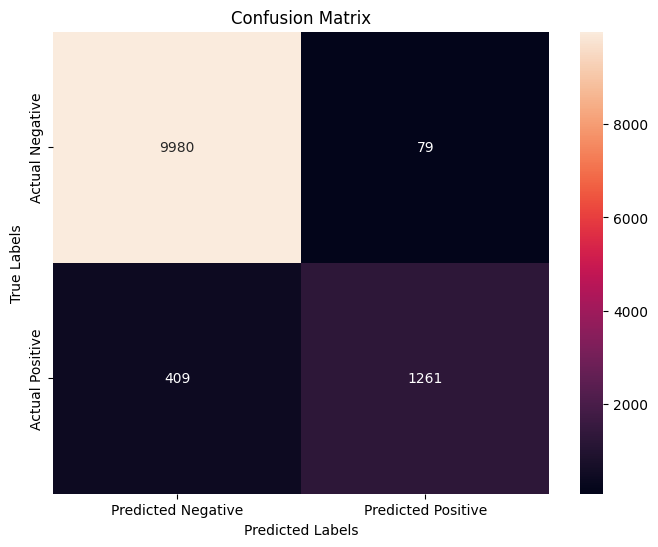

In [98]:
# Calculating confusion matrix
cm = confusion_matrix(y_test, predictions)

# visualisation
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [92]:
test_data = pd.get_dummies(test_data, columns=cat_features, drop_first=True)
bool_features = list(test_data.columns[test_data.dtypes == bool])
test_data[bool_features] = test_data[bool_features].astype(int)

In [93]:
test_predictions = voting_clf.predict_proba(test_data)[:, 1]

In [94]:
# Create the submission DataFrame based on the sample_submission structure
submission = sample_submission.copy()
submission['loan_status'] = test_predictions

# Save to CSV in the required format
submission.to_csv("submission.csv", index=False)
print("Submission file created successfully as 'submission.csv'")

Submission file created successfully as 'submission.csv'
